# Convolutional Autoencoder with K-Means for CIFAR-10

In [1]:
import torch
import numpy as np
from torchvision import datasets
import torchvision
import torchvision.transforms as transforms
from torch.utils.tensorboard import SummaryWriter
import torch.nn as nn
import torch.nn.functional as F
import time

# to import CIFAR-10 as torch tensor
transform = transforms.ToTensor()

# load the training and test datasets
train_data = datasets.CIFAR10(root='data', train=True,
                                   download=True, transform=transform)
test_data = datasets.CIFAR10(root='data', train=False,
                                  download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


## training and testing dataloaders

In [2]:
num_workers = 0
# how many samples per batch to load
batch_size = 100
lr = 1e-3
# how many epochs for training
num_epochs = 20

# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, num_workers=num_workers)

## autoencoder neural network design

In [3]:
class cae(nn.Module):
    def __init__(self):
        super(cae, self).__init__()
        # convolutional encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 12, 3, padding=1),            # [batch, 6, 32, 32]
            nn.ReLU(),
            nn.MaxPool2d(2, 2),                       # [batch, 6, 16, 16]
            nn.Conv2d(12, 24, 5, padding=1),           # [batch, 12, 14, 14]
            nn.ReLU(),
            nn.MaxPool2d(2, 2)                        # [batch, 12, 7, 7]
        )
        #autoencoder bottle neck
        self.latent = nn.Sequential(
            nn.Linear(24*7*7, 50),
        )
        self.upscale = nn.Sequential(
            nn.Linear(50, 12*7*7),
            nn.ReLU(),
        )
        # convolutional decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(12, 6, 4, stride=2),  # [batch, 6, 14, 14]
            nn.ReLU(),
            nn.ConvTranspose2d(6, 3, 2, stride=2),  # [batch, 3, 32, 32]
            nn.Sigmoid(),
        )
        
    # forward learning path
    def forward(self, x):
        x = self.encoder(x)
        bottle_neck = self.latent(x.view(-1, 24*7*7))
        
        x = self.upscale(bottle_neck)
        x = self.decoder(x.view(-1, 12, 7, 7))
        return x, bottle_neck

## CAE model instantiation

In [4]:
# build a CAE model
model = cae()
# set loss function
criterion = nn.MSELoss()
# choose an optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
print(model)

cae(
  (encoder): Sequential(
    (0): Conv2d(3, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(12, 24, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (latent): Sequential(
    (0): Linear(in_features=1176, out_features=50, bias=True)
  )
  (upscale): Sequential(
    (0): Linear(in_features=50, out_features=588, bias=True)
    (1): ReLU()
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(12, 6, kernel_size=(4, 4), stride=(2, 2))
    (1): ReLU()
    (2): ConvTranspose2d(6, 3, kernel_size=(2, 2), stride=(2, 2))
    (3): Sigmoid()
  )
)


## load wieghts

## training

In [ ]:
for x, y in iter(train_loader):
    images = x
grid = torchvision.utils.make_grid(images[-64:])
tb = SummaryWriter()
tb.add_image('images', grid)

x, y = (0, 0)

for epoch in range(num_epochs):
    train_total_loss = 0
    valid_total_loss = 0
    start_time = time.time()
    for batch_index, data in enumerate(train_loader):
        img, _ = data
        if (batch_index+1)%10 != 0:
            x += 1
            # forward path
            output, embed = model(img)
            loss = criterion(output, img)
            # back propagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_total_loss += loss.item()
            tb.add_scalar('training loss/step', loss.item(), x)
        else:
            y += 1
            with torch.no_grad():
                model.eval()
                output, _ = model(img)
                model.train()
                valid_total_loss += F.mse_loss(output, img).item()
            tb.add_scalar('validation loss/step', F.mse_loss(output, img).item(), y)
    
    # tensorboard stuff
    grid = torchvision.utils.make_grid(output[-64:])
    tb.add_image('images', grid)
    tb.add_histogram('test histo', embed, epoch)
    tb.add_scalar('training loss', train_total_loss/(45000/batch_size), epoch)
    tb.add_scalar('validation loss', valid_total_loss/(5000/batch_size), epoch)    
    end_time = time.time()
    
    # log
    print('epoch [{}/{}], training loss:{:.4f}, validation loss:{:.4f}, expected runtime:{:.4f} min'
          .format(epoch+1, num_epochs, train_total_loss/(45000/batch_size), valid_total_loss/(5000/batch_size),
                  (end_time - start_time)*num_epochs/60))

## visualizing reconstructed results
### NOTE TO SELF: to be automated through DV

In [6]:
import matplotlib.pyplot as plt

dataiter = iter(test_loader)
images, _ = dataiter.next()
model.eval()

# get sample outputs
with torch.no_grad():
    output, _ = model(images)
# prep images for display
images = images.numpy()# output is resized into a batch of iages
output = output.view(batch_size, 3, 32, 32)
# use detach when it's an output that requires_grad
output = output.detach().numpy()

# plot the first ten input images and then reconstructed images
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(25,4))

# input images on top row, reconstructions on bottom
for images, row in zip([images, output], axes):
    for img, ax in zip(images, row):
        ax.imshow(img.transpose((1, 2, 0)))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
plt.show()

<Figure size 2500x400 with 20 Axes>

## reconstruct the entire dataset
### NOTE TO SELF: eval to be used to stop regularization

In [7]:
# run the dataset through the trained model
model.eval()
for image_index, data in enumerate(train_loader):
    images, itr_labels = data
    # forward pass: compute embedded outputs by passing inputs to the model
    decoded, encoded = model(images)
    if not image_index:
        #First group encoded in new array
        embedded = encoded.detach().numpy()
        #first group decoded
        disembedded = decoded.detach().numpy()
        #labels
        labels = itr_labels.detach().numpy()
        continue
    #stacking the remaining data
    embedded = np.vstack((embedded, encoded.detach().numpy()))
    disembedded = np.vstack((disembedded, decoded.detach().numpy()))
    labels = np.hstack((labels, itr_labels.detach().numpy()))

## clustering model instantiation and training

In [8]:
from sklearn.cluster import KMeans

# create a k-means model to cluster the embedded features
clustering_model = KMeans(n_clusters=10, tol = 1e-6, max_iter = 400).fit(embedded)

## visualizing results and performance evaluation

### testing autoencoder

In [9]:
# run the dataset through the trained model
model.eval()
for image_index, data in enumerate(test_loader):
    images, itr_labels = data
    # forward pass: compute embedded outputs by passing inputs to the model
    decoded, encoded = model(images)
    if not image_index:
        #First group encoded in new array
        embedded_test = encoded.detach().numpy()
        #first group decoded
        disembedded_test = decoded.detach().numpy()
        #labels
        labels_test = itr_labels.detach().numpy()
        continue
    #stacking the remaining data
    embedded_test = np.vstack((embedded_test, encoded.detach().numpy()))
    disembedded_test = np.vstack((disembedded_test, decoded.detach().numpy()))
    labels_test = np.hstack((labels_test, itr_labels.detach().numpy()))

In [10]:
labels_pred = clustering_model.predict(embedded_test)

In [11]:
import import_ipynb
import DataVisuals as dv


view_results = dv.DataVisuals(disembedded, labels, clustering_model.labels_)
view_results_test = dv.DataVisuals(disembedded_test, labels_test, labels_pred)

importing Jupyter notebook from DataVisuals.ipynb


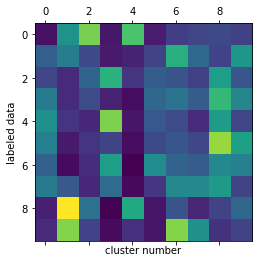

In [12]:
view_results.cm()

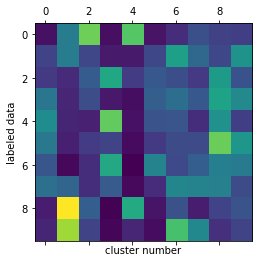

In [13]:
view_results_test.cm()

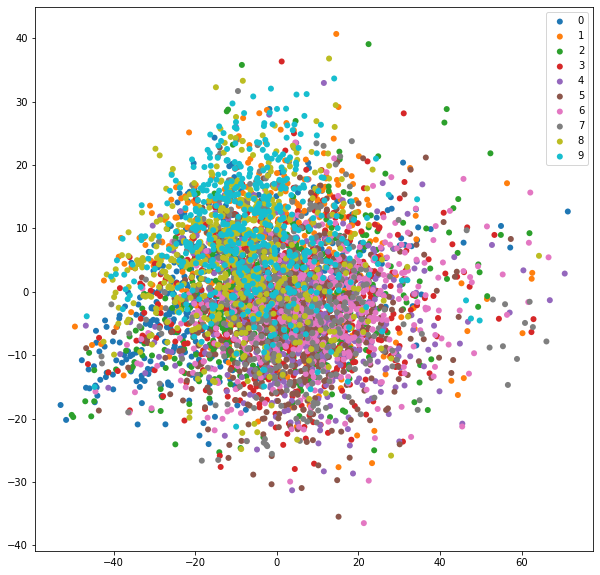

In [14]:
view_results.scat(embedded)

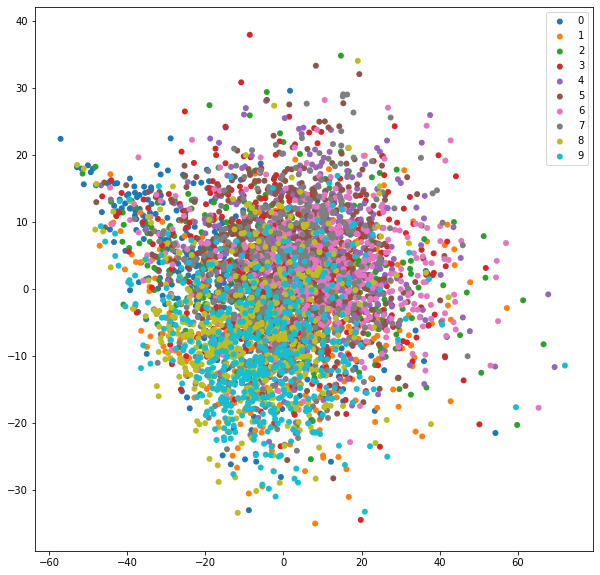

In [15]:
view_results_test.scat(embedded_test)

In [16]:
metric = dv.Metrics(labels, clustering_model.labels_)
nmi = metric.nmi()
ari = metric.ari()
acc = metric.acc()
print('NMI = {:.4f} \nARI = {:.4f} \nACC = {:.4f}'.format(nmi, ari, acc))

C:\Users\Hassan\Anaconda3\lib\site-packages\sklearn\metrics\cluster\supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)
C:\Users\Hassan\Anaconda3\lib\site-packages\sklearn\utils\linear_assignment_.py:21: DeprecationWarning: The linear_assignment_ module is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
C:\Users\Hassan\Anaconda3\lib\site-packages\sklearn\utils\linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


NMI = 0.0929 
ARI = 0.0474 
ACC = 0.2073


In [17]:
metric = dv.Metrics(labels_test, labels_pred)
nmi = metric.nmi()
ari = metric.ari()
acc = metric.acc()
print('NMI = {:.4f} \nARI = {:.4f} \nACC = {:.4f}'.format(nmi, ari, acc))

C:\Users\Hassan\Anaconda3\lib\site-packages\sklearn\metrics\cluster\supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)
C:\Users\Hassan\Anaconda3\lib\site-packages\sklearn\utils\linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


NMI = 0.0994 
ARI = 0.0506 
ACC = 0.2095


## store wieghts